In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from datetime import datetime
import seaborn as sns
import pickle
sns.set_style("whitegrid")

Our next task is to get the "opening" cutoff week for each movie based on the threshold from the box office data

# Compute the Opening Week Cutoff and Multiplier for each movie

In [2]:
boxOffice = pickle.load( open( "LeapReallyCleanedBoxofficeData.p", "rb" ) )
multiplierDataFrame = pd.DataFrame(columns=('title', 'Opening Week', 'Opening Week Number', 'Multiplier'))
i=0
threshold = 0.6
for title in boxOffice:
    cleanTitle = title.split(' (')[0] # Remove Year Tag
    widestWeek = max(boxOffice[title].Theaters)
    startingWeek = 0
    currentWeek = 0
    startingWeek = boxOffice[title][boxOffice[title].Theaters>=threshold*widestWeek].Week.min()
    # weekCutoffs[cleanTitle] = pd.to_datetime(boxOffice[title].at[startingWeek, 'Date'])
    opening = sum(boxOffice[title].Weekly.iloc[0:startingWeek].values)
    total = sum(boxOffice[title].Weekly.values)
    multiplier = total/opening
    multiplierDataFrame.loc[i] = [cleanTitle, pd.to_datetime(boxOffice[title].at[startingWeek, 'Date']), startingWeek, multiplier]
    i+=1
multiplierDataFrame.head()

,title,Opening Week,Opening Week Number,Multiplier
0,Alien,1979-06-22,5,2.416036
1,Raging Bull,1980-12-19,6,1.000000
2,Star Wars: Episode V - The Empire Strikes Back,1980-06-20,6,1.590517
3,Modern Problems,1981-12-25,1,3.600396
4,On Golden Pond,1982-02-12,11,3.246197


In [3]:
# read in review and movie data into data frames
dfs = pd.read_csv('./cleandata/rotten_tomatoes_movie_reviews_clean_scale.csv', index_col=False)
dfm = pd.read_csv('./cleandata/rotten_tomatoes_movies_clean.csv', index_col=False)

rottenMovies = dfm.filter(['id', 'title']) # One line per movie with id, title, and "Release Date"
rottenReviews = dfs.filter(['id', 'creationDate', 'isTopCritic', 'originalScore']) # One line per review with normalized score, etc.
rottenReviews['binaryScore'] = [0 if sS == "NEGATIVE" else 1 for sS in dfs['scoreSentiment']] # Convert sentiment to numerical value
movie_ids_winfo = pd.unique(rottenMovies['id']).tolist() # unique list of movie ids from movie list

rottenReviewsWithTitles = rottenReviews.merge(rottenMovies, how='inner', on='id')
rottenReviewsWithMultipliers = rottenReviewsWithTitles.merge(multiplierDataFrame, how='inner', on='title')
rottenReviewsWithMultipliers['creationDate'] = pd.to_datetime(rottenReviewsWithMultipliers['creationDate'])
rottenReviewsWithMultipliers.head()

,id,creationDate,isTopCritic,originalScore,binaryScore,title,Opening Week,Opening Week Number,Multiplier
0,addicted_2014,2019-09-06,False,0.200,0,Addicted,2014-10-10,1,1.855915
1,addicted_2014,2015-01-09,False,0.000,0,Addicted,2014-10-10,1,1.855915
2,addicted_2014,2014-10-16,True,0.425,0,Addicted,2014-10-10,1,1.855915
3,addicted_2014,2014-10-11,True,0.375,0,Addicted,2014-10-10,1,1.855915
4,addicted_2014,2014-10-10,True,0.300,0,Addicted,2014-10-10,1,1.855915


# Computing Early Reviews and Looking at their distributions

To get a sense for how critics score movies numerically, let's look at distribution the average score for each movie to see what a baseline is to help define what "neutral" reviews might look like and to use that to help define out null hypothesis.

In [4]:
earlyReviewsWithMultipliers = rottenReviewsWithMultipliers.loc[rottenReviewsWithMultipliers['creationDate']<=rottenReviewsWithMultipliers['Opening Week']]
earlyTopReviewsWithMultipliers = rottenReviewsWithMultipliers.loc[(rottenReviewsWithMultipliers['creationDate']<=rottenReviewsWithMultipliers['Opening Week']) \
 & (rottenReviewsWithMultipliers.isTopCritic)]

avgEarlyReviews = earlyReviewsWithMultipliers.filter(['title', 'originalScore', 'binaryScore', 'Multiplier']).groupby(['title']).mean()
avgEarlyReviewsInfo = avgEarlyReviews.merge(dfm.filter(['genre', 'rating', 'title', 'id']), how='inner', on='title').dropna()

avgEarlyTopReviews = earlyTopReviewsWithMultipliers.filter(['title', 'originalScore', 'binaryScore', 'Multiplier']).groupby(['title']).mean()
avgEarlyTopReviewsInfo = avgEarlyTopReviews.merge(dfm.filter(['genre', 'rating', 'title', 'id']), how='inner', on='title').dropna()

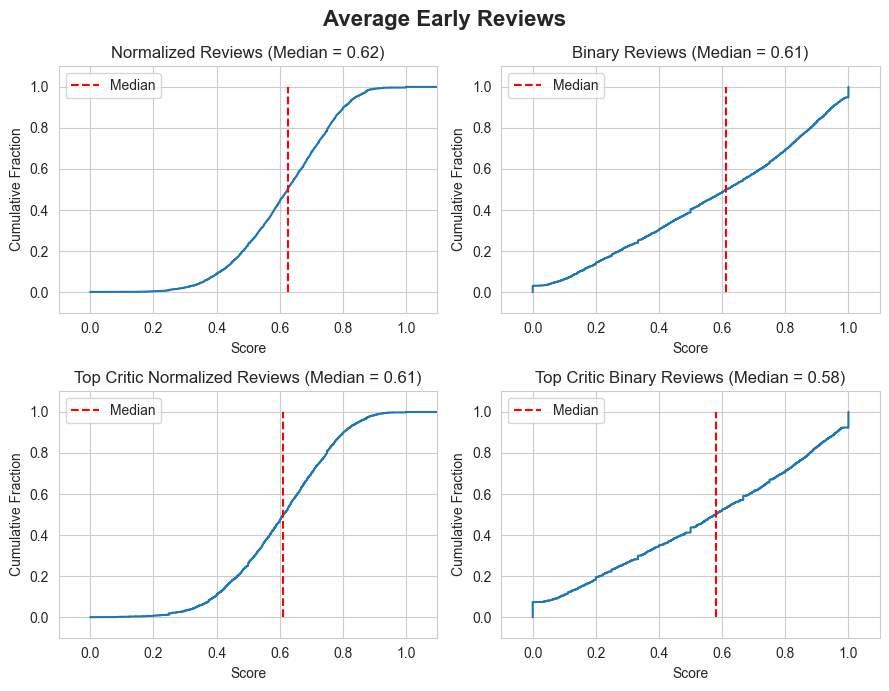

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(9, 7), layout='tight')
fig.suptitle('Average Early Reviews', fontweight='bold', fontsize=16)
ax[0,0].ecdf(avgEarlyReviews.originalScore)
ax[0,0].set_title('Normalized Reviews (Median = %.2f)' % avgEarlyReviews.originalScore.median())
ax[0,0].vlines(avgEarlyReviews.originalScore.median(), 0, 1, colors='r', linestyles='dashed', label='Median')
ax[0,1].ecdf(avgEarlyReviews.binaryScore)
ax[0,1].set_title('Binary Reviews (Median = %.2f)' % avgEarlyReviews.binaryScore.median())
ax[0,1].vlines(avgEarlyReviews.binaryScore.median(), 0, 1, colors='r', linestyles='dashed', label='Median')
ax[1,0].ecdf(avgEarlyTopReviews.originalScore)
ax[1,0].set_title('Top Critic Normalized Reviews (Median = %.2f)' % avgEarlyTopReviews.originalScore.median())
ax[1,0].vlines(avgEarlyTopReviews.originalScore.median(), 0, 1, colors='r', linestyles='dashed', label='Median')
ax[1,1].ecdf(avgEarlyTopReviews.binaryScore)
ax[1,1].set_title('Top Critic Binary Reviews (Median = %.2f)' % avgEarlyTopReviews.binaryScore.median())
ax[1,1].vlines(avgEarlyTopReviews.binaryScore.median(), 0, 1, colors='r', linestyles='dashed', label='Median')
for i in range(2):
    for j in range(2):
        ax[i,j].set_xlabel('Score')
        ax[i,j].set_ylabel('Cumulative Fraction')
        ax[i,j].set_xlim([-0.1, 1.1])
        ax[i,j].set_ylim([-0.1, 1.1])
        ax[i,j].legend()

As these plots show, reviews do tend to skew slightly above 0.5 and the median review across all these metrics is close to 0.6. It would also seem that top critic rating patterns follow pretty closely with the rest of the critics. However it is interesting to note that top critics seem to be slightly more likely to be unanimous as to whether a movie is rotten or fresh as judged by the vertical jumps in the binary review CDFs at 0 and 1. For the purposes of creating subsets of movies grouped by early reviews for hypothesis testing, we will group movies between 0.5 and 0.7 as "neutral reviews" since this captures about the middle 60% for the various review types. That leaves us with two other groups for bad and great reviews.

# Multiplier Distributions by Early Reviews

So what happens when we separately consider movies that have good, neutral, and bad early reviews. Does this seem to affect (or at least correlate) with a movie's multiplier or how well a movie plays after it's opening week(s)? To qualitatively analyze this we have separated movies into groups of bad, neutral, and good reviews based on cutoffs chosen from looking at the CDF plots. As discussed above, we think these cutoffs will fit well across the different review and scoring types. They are as follows. 

$$
\text{Bad Reviews}        = \{0<\text{Average Review}<0.5\}\\
\text{Neutral Reviews}        = \{0.5<\text{Average Review}<0.7\}\\
\text{Good Reviews}        = \{0.7<\text{Average Review}<1\}
$$

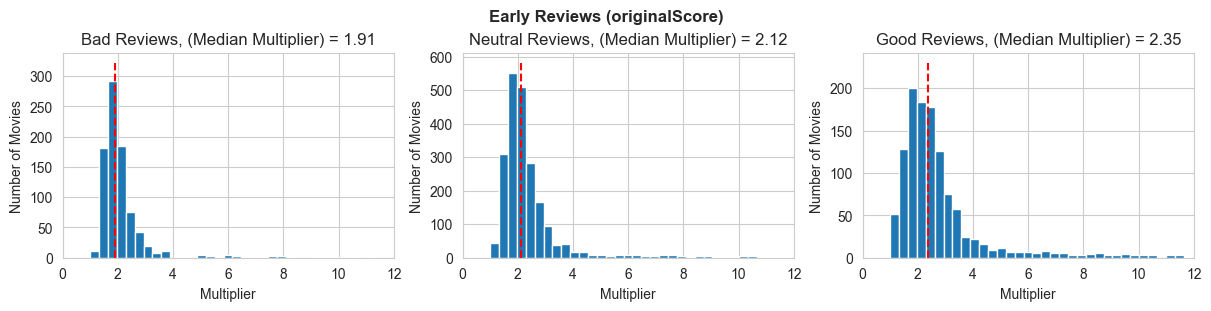

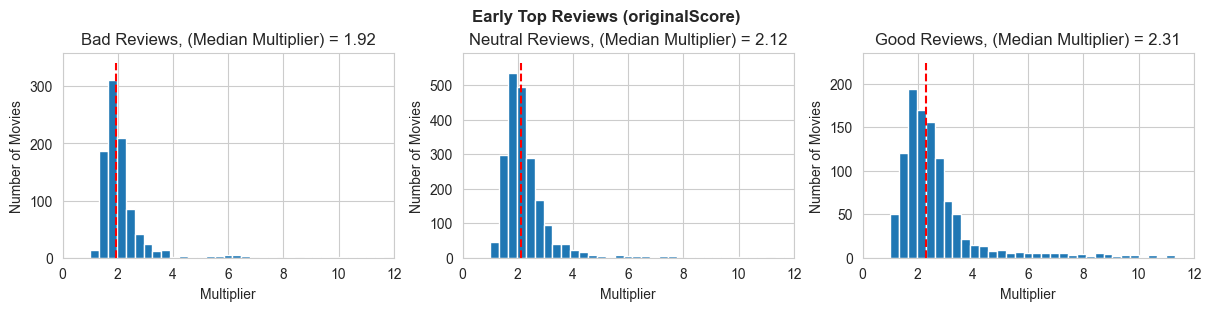

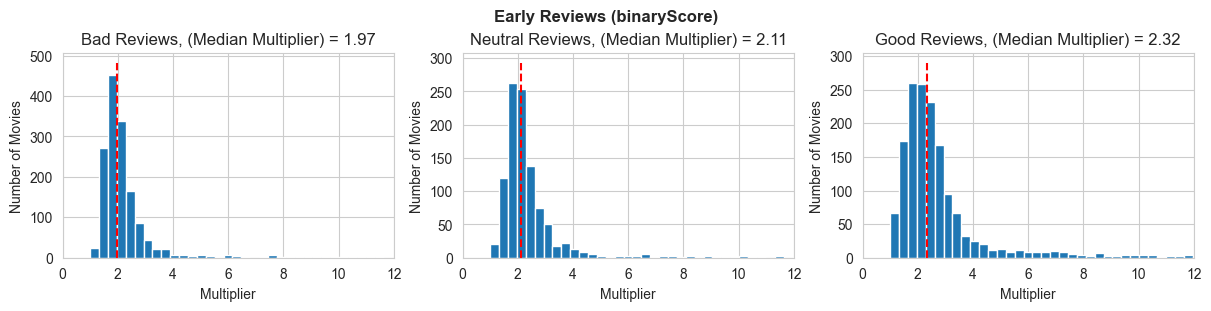

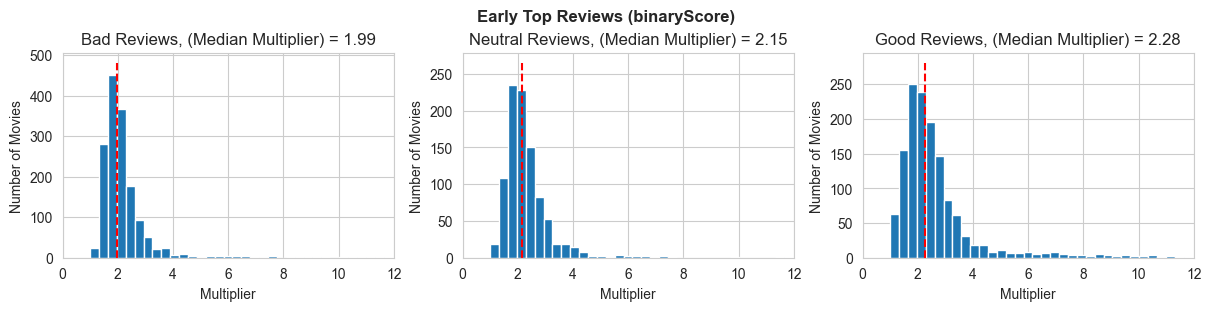

In [15]:
avgEarlyReviews = earlyReviewsWithMultipliers.filter(['title', 'originalScore', 'binaryScore', 'Multiplier']).groupby(['title']).mean()
avgEarlyReviewsInfo = avgEarlyReviews.merge(dfm.filter(['genre', 'rating', 'title', 'id']), how='inner', on='title').dropna()

reviewTypes = [avgEarlyReviews, avgEarlyTopReviews]
typeNames = ['Early Reviews', 'Early Top Reviews']
scoreTypes = ['originalScore', 'binaryScore']

for scoreType in scoreTypes:
    j=0
    for reviewType in reviewTypes:
        fig, ax = plt.subplots(1, 3, figsize=(12, 3), layout='constrained')
        ax[0].set_title('Bad Reviews, (Median Multiplier) = %.2f' %reviewType.loc[reviewType[scoreType].between(0, 0.5)].Multiplier.median())
        
        ax[1].set_title('Neutral Reviews, (Median Multiplier) = %.2f' %reviewType.loc[reviewType[scoreType].between(0.5, 0.7)].Multiplier.median())
        ax[2].set_title('Good Reviews, (Median Multiplier) = %.2f' %reviewType.loc[reviewType[scoreType].between(0.7, 1)].Multiplier.median())
        counts0, bins0, patches0 = ax[0].hist(reviewType.loc[reviewType[scoreType].between(0, 0.5)].Multiplier, bins=np.linspace(1, 20, 60))
        ax[0].vlines(reviewType.loc[reviewType[scoreType].between(0, 0.5)].Multiplier.median(), 0, counts0.max()+30, colors='r', linestyles='dashed', label='Median')
        counts1, bins1, patches1 = ax[1].hist(reviewType.loc[reviewType[scoreType].between(0.4, 0.7)].Multiplier, bins=np.linspace(1, 20, 60))
        ax[1].vlines(reviewType.loc[reviewType[scoreType].between(0.5, 0.7)].Multiplier.median(), 0, counts1.max()+30, colors='r', linestyles='dashed', label='Median')
        counts2, bins2, patches2 = ax[2].hist(reviewType.loc[reviewType[scoreType].between(0.7, 1)].Multiplier, bins=np.linspace(1, 20, 60))
        ax[2].vlines(reviewType.loc[reviewType[scoreType].between(0.7, 1)].Multiplier.median(), 0, counts2.max()+30, colors='r', linestyles='dashed', label='Median')
        for i in range(3):
            ax[i].set_xlim([0, 12])
            ax[i].set_xlabel('Multiplier')
            ax[i].set_ylabel('Number of Movies')
        fig.suptitle(typeNames[j] +' ('+scoreType+')', weight='bold')
        j+= 1

As we had hoped, there is a clear shift in the distribution of the multiplier showing that movies with good reviews tend to play better over time compared to average reviews and that those with bad reviews fair worse. This shift seems quite consistent across review metrics looking at the binary classified scores as well as the normalized scale score of the critics. Particularly notable are the high multiplier outliers which tend to be found in the good review section. Next let's quantify this shift in the distribution with some hypothesis testing. Going forward we will stick with the normalized original scores for the review data.

# Hypothesis Testing
### Comparing movies with good and bad early reviews to those with neutral reviews
We would like to compute p-values comparing the multiplier distributions for the sets of movies with good and bad early reviews to the distribution from movies with neutral reviews. One obvious challenge this data presents is that it is clearly not normally distributed. Of particular concern is the fact that the multiplier cannot take on a value below 1 (which corresponds to a movie which made all of its money during its opening). Given the large sample sizes of these distributions (thousands of movies), we might consider using a Student's t-test despite the non-normality of the multiplier distribution. However to avoid problems which may occur as we begin looking at smaller sections of the data, we have opted to use a non-parametric test, particularly the Mann–Whitney U test to assess the statistical significance of these shifts in multiplier values.

In [7]:
from scipy.stats import mannwhitneyu
badReviews = avgEarlyReviews.loc[avgEarlyReviews.originalScore.between(0, 0.5)]
neutralReviews = avgEarlyReviews.loc[avgEarlyReviews.originalScore.between(0.5, 0.7)]
goodReviews = avgEarlyReviews.loc[avgEarlyReviews.originalScore.between(0.7, 1)]

data = {
    'Early Reviews': ['Bad', 'Good'],
    'Median Multiplier': [badReviews.Multiplier.median(), goodReviews.Multiplier.median()],
    'Mann-Whitney p-value': [mannwhitneyu(badReviews.Multiplier, neutralReviews.Multiplier).pvalue,
                          mannwhitneyu(goodReviews.Multiplier, neutralReviews.Multiplier).pvalue]
    
}
pd.DataFrame(data)

,Early Reviews,Median Multiplier,Mann-Whitney p-value
0,Bad,1.911224,1.128664e-19
1,Good,2.353561,2.233738e-08


Both good and bad reviews have a statistically significant difference in multiplier distributions as suggested by the low p-values. In other words, the difference in good and bad review multiplier distributions as compared to neutral reviews is highly unlikely to be due to sample variation at this sample size. Thus, we should reject the null hypothesis that good and bad review multipliers were drawn from the same underlying distribution as those with neutral reviews. Not only are these differences statistically significant, but we argue they are practically significant. Since,

$$ 
\frac{\text{Total Gross}}{\text{Opening}} = \text{Multiplier}, \qquad
\text{Total Gross} = (\text{Multiplier})(\text{Opening})
$$

The change in total gross for movies based on review data is:

$$
\text{Total Gross}_0 = (\text{Multiplier}_0) (\text{Opening}), \qquad \text{Total Gross}_1 = (\text{Multiplier}_0 + D) (\text{Opening})
$$
Considering the same opening gross and a difference in multiplier $D = \text{Multiplier}_1 - \text{Multiplier}_0$ correlated with the reviews.

$$
\text{Total Gross}_1 = \text{Total Gross}_0 \left(1+\frac{D}{\text{Multiplier}_0}\right)
$$

A 0.4 difference in the multiplier corresponds to a ~23% increase in total gross given the same opening (assuming a median negative review multiplier of 1.91). For most of the movies considered, this corresponds to millions of dollars. So not only does the p-test show that these differences are **statistically significant**, but the measured differences in median multipliers show that generally this is a **practically significant** difference. Next we will look at the statistical and practical significance of these differences when further dividing the data to different genres.

### Genre differences in review-multiplier correlation

In [8]:
badReviewsInfo = avgEarlyReviewsInfo.loc[avgEarlyReviewsInfo.originalScore.between(0, 0.5)]
neutralReviewsInfo = avgEarlyReviewsInfo.loc[avgEarlyReviewsInfo.originalScore.between(0.5, 0.7)]
goodReviewsInfo = avgEarlyReviewsInfo.loc[avgEarlyReviewsInfo.originalScore.between(0.7, 1)]

rawGenres = pd.unique(avgEarlyReviewsInfo['genre']).tolist()
separatedGenres = []
for genre in rawGenres:
    if ', ' in genre:
        separatedGenres.extend(genre.split(', '))
    else:
        separatedGenres.append(genre)
genres = list(set(separatedGenres))

df = pd.DataFrame(columns=['Bad Review Multiplier','Good Review Multiplier','Bad p-value','Good p-value', 'Good-Bad Multiplier Difference', 'Sample Sizes'])
for singleGenre in genres:
    badGenre = badReviewsInfo[badReviewsInfo.genre.str.contains(singleGenre)]
    neutralGenre = neutralReviewsInfo[neutralReviewsInfo.genre.str.contains(singleGenre)]
    goodGenre = goodReviewsInfo[goodReviewsInfo.genre.str.contains(singleGenre)]
    if min(len(badGenre), len(neutralGenre), len(goodGenre)) >50:
        df.loc[singleGenre] = pd.Series({'Bad Review Multiplier': badGenre.Multiplier.median(),'Good Review Multiplier': goodGenre.Multiplier.median(),
                                        'Bad p-value' : '%.1e'% mannwhitneyu(badGenre.Multiplier, neutralGenre.Multiplier).pvalue,
                                        'Good p-value': '%.1e'% mannwhitneyu(goodGenre.Multiplier, neutralGenre.Multiplier).pvalue,
                                        'Good-Bad Multiplier Difference': goodGenre.Multiplier.median() - badGenre.Multiplier.median(),
                                            'Sample Sizes': '%d-%d-%d' % (len(badGenre), len(neutralGenre), len(goodGenre))
                                        })
    
# df['Bad p-value']
# display(df.sort_values(by='Good-Bad Multiplier range', ascending=False))
df.sort_values(by='Good-Bad Multiplier Difference', ascending=False).style.apply(lambda x: ["background: red" if (float(v) > 0.05) else "background: green" for v in x], \
                                                                             axis = 1, subset=['Bad p-value', 'Good p-value'])
# df.style.apply(lambda x: ["background: red" if (float(v) > 0.05) else "" for v in x], axis = 1, subset=['Bad p-value', 'Good p-value'])

,Bad Review Multiplier,Good Review Multiplier,Bad p-value,Good p-value,Good-Bad Multiplier Difference,Sample Sizes
Sci-fi,1.760050,2.353738,3.1e-03,1.1e-04,0.593688,63-110-77
Adventure,1.943829,2.493433,5.7e-05,6.9e-05,0.549605,126-305-155
Kids & family,2.313115,2.829868,2.7e-02,4.2e-05,0.516753,73-144-68
Mystery & thriller,1.840418,2.303455,7.6e-08,3.2e-05,0.463037,237-377-208
Action,1.821309,2.283809,6.3e-09,1.9e-04,0.462500,204-324-137
Fantasy,1.838658,2.286519,9.3e-08,1.4e-01,0.447861,75-157-110
Drama,1.869054,2.240189,8.0e-07,7.1e-03,0.371135,180-700-637
Comedy,1.999007,2.306235,1.0e-06,2.1e-01,0.307228,371-623-314
Horror,1.788937,2.086933,1.2e-02,1.4e-02,0.297996,138-141-59
Romance,2.093837,2.224277,1.9e-01,1.6e-01,0.130440,112-206-108


Breaking down the review multiplier analysis by genre offers some pretty powerful insights into how much the long-term success of movies of different genres correlates with review data. Of particular note is that the difference in multipliers was less for certain genres like romance and horror. In the industry these genres are often thought to have a "built-in" audience of fans and thus be less susceptible to the influence of reviewers. I think this data supports that conclusion. It also suggests that good early reviews are particularly important for the long-term success of sci-fi movies where the good-bad multiplier disparity is largest and to a high degree of statistical significance (each compared to neutral reviews). In the cases of Fantasy and Comedy movies, the multiplier differences between good and neutral reviews was not significant, but the difference between bad and neutral-reviewed movies was significant. So in that case, really excellent reviews may not help in the long-run, but bad reviews are clearly correlated with worse performance after opening.